# Homework:
# Deep Convolutional Generative Adversarial Network 

Description of an implementation of DCGAN can be found in [Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks](https://arxiv.org/abs/1511.06434).

In [8]:
#Import the libraries we will need.
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import tensorflow.contrib.slim as slim
import os
import scipy.misc
import scipy

We will be using the MNIST dataset. input_data is a library that downloads the dataset and uzips it automatically.

In [2]:
mnist = input_data.read_data_sets('fashion-mnist/data/fashion', one_hot=False)

Extracting fashion-mnist/data/fashion/train-images-idx3-ubyte.gz
Extracting fashion-mnist/data/fashion/train-labels-idx1-ubyte.gz
Extracting fashion-mnist/data/fashion/t10k-images-idx3-ubyte.gz
Extracting fashion-mnist/data/fashion/t10k-labels-idx1-ubyte.gz


### Helper Functions

In [3]:
#This function performns a leaky relu activation, which is needed for the discriminator network.
def lrelu(x, leak=0.2, name="lrelu"):
    with tf.variable_scope(name):
        f1 = 0.5 * (1 + leak)
        f2 = 0.5 * (1 - leak)
        return f1 * x + f2 * abs(x)
    
#The below functions are taken from carpdem20's implementation https://github.com/carpedm20/DCGAN-tensorflow
#They allow for saving sample images from the generator to follow progress
def save_images(images, size, image_path):
    return imsave(inverse_transform(images), size, image_path)

def imsave(images, size, path):
    return scipy.misc.imsave(path, merge(images, size))

def inverse_transform(images):
    return (images+1.)/2.

def merge(images, size):
    h, w = images.shape[1], images.shape[2]
    img = np.zeros((h * size[0], w * size[1]))

    for idx, image in enumerate(images):
        i = idx % size[1]
        j = idx // size[1]
        img[j*h:j*h+h, i*w:i*w+w] = image

    return img

## Defining the Adversarial Networks

### Generator Network

In [4]:
def generator(z):
    
    zP = slim.fully_connected(z,4*4*256,normalizer_fn=slim.batch_norm,\
        activation_fn=tf.nn.relu,scope='g_project',weights_initializer=initializer)
    zCon = tf.reshape(zP,[-1,4,4,256])
    
    gen1 = slim.convolution2d_transpose(\
        zCon,num_outputs=64,kernel_size=[5,5],stride=[2,2],\
        padding="SAME",normalizer_fn=slim.batch_norm,\
        activation_fn=tf.nn.relu,scope='g_conv1', weights_initializer=initializer)
    
    gen2 = slim.convolution2d_transpose(\
        gen1,num_outputs=32,kernel_size=[5,5],stride=[2,2],\
        padding="SAME",normalizer_fn=slim.batch_norm,\
        activation_fn=tf.nn.relu,scope='g_conv2', weights_initializer=initializer)
    
    gen3 = slim.convolution2d_transpose(\
        gen2,num_outputs=16,kernel_size=[5,5],stride=[2,2],\
        padding="SAME",normalizer_fn=slim.batch_norm,\
        activation_fn=tf.nn.relu,scope='g_conv3', weights_initializer=initializer)
    
    g_out = slim.convolution2d_transpose(\
        gen3,num_outputs=1,kernel_size=[32,32],padding="SAME",\
        biases_initializer=None,activation_fn=tf.nn.tanh,\
        scope='g_out', weights_initializer=initializer)
    
    return g_out

### Discriminator Network

### Task1 (13 points)
Fill parameter for the discrimiator architecture

In [13]:
def discriminator(bottom, reuse=False):
    with slim.arg_scope([slim.fully_connected, slim.convolution2d], reuse=reuse, weights_initializer=initializer):
        # Your code here
        dis1 = slim.convolution2d(bottom, scope='d_conv1', 
                                  num_outputs=16, 
                                  kernel_size=[4, 4], 
                                  stride=[2,2], 
                                  padding='SAME', 
                                  activation_fn=lrelu,
                                  reuse=reuse,
                                  weights_initializer=initializer,
                                  biases_initializer=None)
                                  

        dis2 = slim.convolution2d(dis1, scope='d_conv2',
                                  num_outputs=32,
                                  kernel_size=[4,4],
                                  stride=[2,2],
                                  padding='SAME',
                                  normalizer_fn=slim.batch_norm,
                                  activation_fn=lrelu,
                                  reuse=reuse,
                                  weights_initializer=initializer,
                                  biases_initializer=None)

        dis3 = slim.convolution2d(dis2, 
                                  scope='d_conv3',
                                  num_outputs=64,
                                  kernel_size=[4,4],
                                  stride=[2,2],
                                  padding="SAME",
                                  normalizer_fn=slim.batch_norm,
                                  activation_fn=lrelu,
                                  reuse=reuse,
                                  weights_initializer=initializer,
                                  biases_initializer=None)

        d_out = slim.fully_connected(slim.flatten(dis3), scope='d_out',
                                     num_outputs=1,
                                     activation_fn=tf.nn.sigmoid,
                                     reuse=reuse,
                                     weights_initializer=initializer
                                    )
    
    return d_out

### Connecting them together

In [14]:
tf.reset_default_graph()

z_size = 100 #Size of z vector used for generator.

#This initializaer is used to initialize all the weights of the network.
initializer = tf.truncated_normal_initializer(stddev=0.02)

#These two placeholders are used for input into the generator and discriminator, respectively.
z_in = tf.placeholder(shape=[None,z_size],dtype=tf.float32) #Random vector
real_in = tf.placeholder(shape=[None,32,32,1],dtype=tf.float32) #Real images

Gz = generator(z_in) #Generates images from random z vectors
Dx = discriminator(real_in) #Produces probabilities for real images
Dg = discriminator(Gz,reuse=True) #Produces probabilities for generator images

#These functions together define the optimization objective of the GAN.
d_loss = -tf.reduce_mean(tf.log(Dx) + tf.log(1.-Dg)) #This optimizes the discriminator.
g_loss = -tf.reduce_mean(tf.log(Dg)) #This optimizes the generator.

tvars = tf.trainable_variables()

#The below code is responsible for applying gradient descent to update the GAN.
trainerD = tf.train.AdamOptimizer(learning_rate=0.0002,beta1=0.5)
trainerG = tf.train.AdamOptimizer(learning_rate=0.0002,beta1=0.5)
d_grads = trainerD.compute_gradients(d_loss,tvars[9:]) #Only update the weights for the discriminator network.
g_grads = trainerG.compute_gradients(g_loss,tvars[0:9]) #Only update the weights for the generator network.

update_D = trainerD.apply_gradients(d_grads)
update_G = trainerG.apply_gradients(g_grads)

## Training the network
I strongly advise you to skip this cell and go the the next one since training will take you enormous amount of time

In [ ]:
batch_size = 128 #Size of image batch to apply at each iteration.
iterations = 500000 #Total number of iterations to use.
sample_directory = './figs' #Directory to save sample images from generator in.
model_directory = './models' #Directory to save trained model to.

init = tf.global_variables_initializer()
saver = tf.train.Saver()
with tf.Session() as sess:  
    sess.run(init)
    for i in range(iterations):
        zs = np.random.uniform(-1.0,1.0,size=[batch_size,z_size]).astype(np.float32) #Generate a random z batch
        xs,_ = mnist.train.next_batch(batch_size) #Draw a sample batch from MNIST dataset.
        xs = (np.reshape(xs,[batch_size,28,28,1]) - 0.5) * 2.0 #Transform it to be between -1 and 1
        xs = np.lib.pad(xs, ((0,0),(2,2),(2,2),(0,0)),'constant', constant_values=(-1, -1)) #Pad the images so the are 32x32
        _,dLoss = sess.run([update_D,d_loss],feed_dict={z_in:zs,real_in:xs}) #Update the discriminator
        _,gLoss = sess.run([update_G,g_loss],feed_dict={z_in:zs}) #Update the generator, twice for good measure.
        _,gLoss = sess.run([update_G,g_loss],feed_dict={z_in:zs})
        if i % 10 == 0:
            print("Gen Loss: " + str(gLoss) + " Disc Loss: " + str(dLoss))
            z2 = np.random.uniform(-1.0,1.0,size=[batch_size,z_size]).astype(np.float32) #Generate another z batch
            newZ = sess.run(Gz,feed_dict={z_in:z2}) #Use new z to get sample images from generator.
            if not os.path.exists(sample_directory):
                os.makedirs(sample_directory)
            #Save sample generator images for viewing training progress.
            save_images(np.reshape(newZ[0:36],[36,32,32]),[6,6],sample_directory+'/fig'+str(i)+'.png')
        if i % 1000 == 0 and i != 0:
            if not os.path.exists(model_directory):
                os.makedirs(model_directory)
            saver.save(sess,model_directory+'/model-'+str(i)+'.cptk')
            print("Saved Model")

## Using a trained network
Once we have a trained model saved, we may want to use it to generate new images, and explore the representation it has learned.

In [43]:
sample_directory = './figs' #Directory to save sample images from generator in.
model_directory = './models' #Directory to load trained model from.

batch_size_sample = 36

init = tf.global_variables_initializer()
saver = tf.train.Saver()
with tf.Session() as sess:  
    sess.run(init)
    #Reload the model.
    print( 'Loading Model...')
    ckpt = tf.train.get_checkpoint_state(model_directory)
    saver.restore(sess,ckpt.model_checkpoint_path)
    
    zs = np.random.uniform(-1.0,1.0,size=[batch_size_sample,z_size]).astype(np.float32) #Generate a random z batch
    newZ = sess.run(Gz,feed_dict={z_in:zs}) #Use new z to get sample images from generator.
    if not os.path.exists(sample_directory):
        os.makedirs(sample_directory)
        
    for i in range(newZ.shape[0]):
        scipy.misc.imsave(sample_directory+'/fig'+str(i)+'.png', 
                          newZ[i].reshape([32, 32]))

Loading Model...
INFO:tensorflow:Restoring parameters from ./models/model-499000.cptk


### Task 2 (2 points)
Run a couple of iterations and visualize examples generated by the generator (Could be found in ./fig folder)

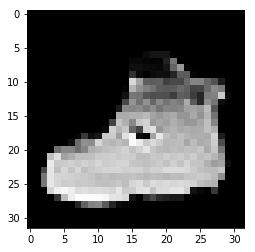

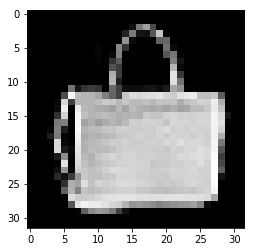

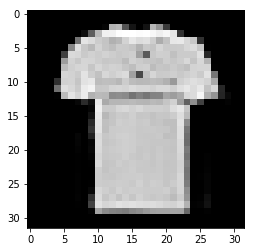

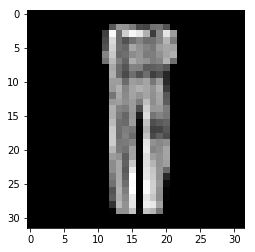

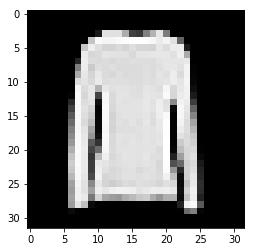

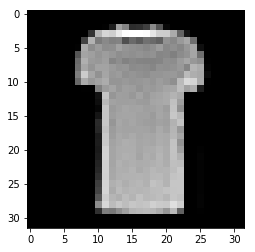

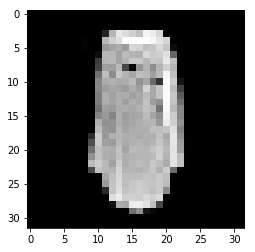

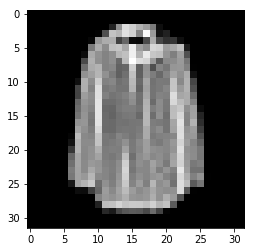

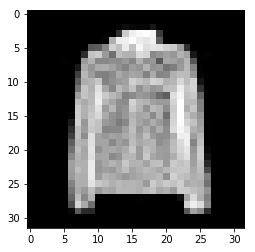

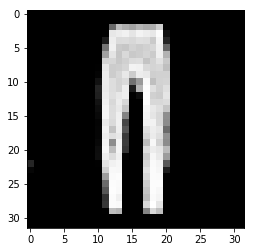

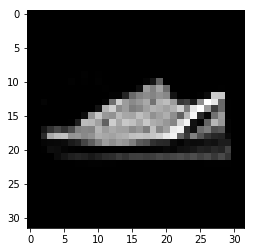

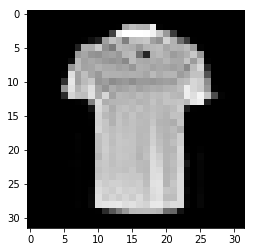

In [44]:
import cv2
for i, fig in enumerate(os.listdir('./figs/')):
    img = cv2.imread('./figs/' + fig)
    plt.imshow(img)
    plt.show()
    if i > 10:
        break

### Task 3 (5 points)
Evaluate discrimator accuracy in the pre-trained model on any representative subsample of fashion-minst

In [83]:
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, accuracy_score

batch_size = 512

init = tf.global_variables_initializer()
saver = tf.train.Saver()

pred_reals = []
pred_gens = []

with tf.Session() as sess:  
    sess.run(init)
    print('Loading Model...')
    ckpt = tf.train.get_checkpoint_state(model_directory)
    saver.restore(sess,ckpt.model_checkpoint_path)
    
    for i in tqdm(range(100)):
        real = mnist.test.next_batch(batch_size)[0]
        real = (np.reshape(real, [batch_size, 28, 28, 1]) - 0.5) * 2.
        real = np.lib.pad(real, ((0,0),(2,2),(2,2),(0,0)),'constant', constant_values=(-1, -1))
        
        predict_real = sess.run(Dx, feed_dict={real_in: real})
        pred_reals.append(predict_real)
        
        generated = np.random.uniform(-1.0, 1.0, size=[batch_size, z_size]).astype(np.float32)
        predict_generated = sess.run(Dg, feed_dict={z_in: generated})
        pred_gens.append(predict_generated)
        
    pred_reals = np.array(pred_reals)
    pred_gens = np.array(pred_gens)
    
    y_pred = np.hstack((pred_reals, pred_gens))
    y_pred = np.reshape(y_pred, newshape=y_pred.shape[0] * y_pred.shape[1])
    
    y_true = np.hstack((np.zeros_like(pred_reals), np.ones_like(pred_gens)))
    y_true = y_true.astype(np.bool)
    y_true = np.reshape(y_true, newshape=y_true.shape[0] * y_true.shape[1])
    
    y_pred_bool = y_pred >= .5
    print('AUC score ' + str(roc_auc_score(y_true, y_pred)))
    print('accuracy score ' + str(accuracy_score(y_true, y_pred_bool)))

Loading Model...
INFO:tensorflow:Restoring parameters from ./models/model-499000.cptk


100%|██████████| 100/100 [03:08<00:00,  1.89s/it]

AUC score 0.782529627037
accuracy score 0.59541015625


In [80]:
print(np.arange(0.0, 1.0, 0.1))
print(np.round(np.arange(0.0, 1.0, 0.1)))

[ 0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9]
[ 0.  0.  0.  0.  0.  0.  1.  1.  1.  1.]
